# Many-Body Tensor Approximation with MNIST

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from ld import LD, get_eta

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import itertools

In [4]:
def block_B(start_idx, end_idx):
    """
    Create a block B of indexes for the center region.

    Parameters:
    - start_idx: int, the starting index of the center region
    - end_idx: int, the ending index of the center region

    Returns:
    - center_region_indexes: numpy array with shape (n, 2), the indexes of the center region
    """
    # Create the index grid
    x, y = np.meshgrid(np.arange(start_idx, end_idx), np.arange(start_idx, end_idx))

    # Flatten the arrays and stack them as coordinate pairs
    center_region_indexes = np.column_stack((x.flatten(), y.flatten()))

    return center_region_indexes

In [5]:
def compute_Q(theta):
        r"""Compute decomposable tensor Q from parameter \theta using Dynamic Programming.

        Parameters
        ----------
        theta : array
            second/third-order tensor.
            Same shapes as input tensor P.

        beta : list
            sets of decomposition basis vectors.

        Returns
        -------
        Q : array
            second/third-order tensor.
            Decomposable tensor.
        """
        idx = theta.shape
        order = len(theta.shape)
        theta_sum = np.zeros(theta.shape)

        if order == 2:
            theta_sum[0, 0] = theta[0, 0]

            # update outside eta.
            for i in range(1, idx[0]):
                theta_sum[i, 0] = theta[i, 0] + theta_sum[i-1, 0]
            for j in range(1, idx[1]):
                theta_sum[0, j] = theta[0, j] + theta_sum[0, j-1]

            # update internal eta.
            for i in range(1, idx[0]):
                for j in range(1, idx[1]):
                    theta_sum[i, j] = theta[i, j] + theta_sum[i-1, j] \
                                        + theta_sum[i, j-1] - theta_sum[i-1, j-1]

        elif order == 3:
            theta_sum[0, 0, 0] = theta[0, 0, 0]

            # update outside eta.
            for i in range(1, idx[0]):
                theta_sum[i, 0, 0] = theta[i, 0, 0] + theta_sum[i-1, 0, 0]
            for j in range(1, idx[1]):
                theta_sum[0, j, 0] = theta[0, j, 0] + theta_sum[0, j-1, 0]
            for k in range(1, idx[2]):
                theta_sum[0, 0, k] = theta[0, 0, k] + theta_sum[0, 0, k-1]

            # update internal eta.
            for i, j in itertools.product(range(1, idx[0]), range(1, idx[1])):
                theta_sum[i, j, 0] = theta[i, j, 0] + theta_sum[i-1, j, 0] \
                                        + theta_sum[i, j-1, 0] - theta_sum[i-1, j-1, 0]
            for j, k in itertools.product(range(1, idx[1]), range(1, idx[2])):
                theta_sum[0, j, k] = theta[0, j, k] + theta_sum[0, j-1, k] \
                                        + theta_sum[0, j, k-1] - theta_sum[0, j-1, k-1]
            for i, k in itertools.product(range(1, idx[0]), range(1, idx[2])):
                theta_sum[i, 0, k] = theta[i, 0, k] + theta_sum[i-1, 0, k] \
                                        + theta_sum[i, 0, k-1] - theta_sum[i-1, 0, k-1]

            for i, j, k in itertools.product(range(1, idx[0]), range(1, idx[1]), range(1, idx[2])):
                theta_sum[i, j, k] = theta[i, j, k] + theta_sum[i-1, j, k] + theta_sum[i, j-1, k] \
                                    + theta_sum[i, j, k-1] - theta_sum[i-1, j-1, k] - theta_sum[i-1, j, k-1] \
                                    - theta_sum[i, j-1, k-1] + theta_sum[i-1, j-1, k-1]

        else:
            raise NotImplementedError("Order of input tensor should be 2 or 3. Order: {}.".format(order))

        Q = np.exp(theta_sum)
        psi = Q.sum()
        Q /= psi

        return Q

In [6]:
UCI_dataset = fetch_ucirepo(id=UCI_id)

X = np.array(UCI_dataset.data.features)
Y = np.array(LabelEncoder().fit_transform(UCI_dataset.data.targets))

# Print the shape of features and labels
print("Shape of features:", X.shape)
print("Shape of labels:", Y.shape)

# Find unique labels
unique_labels = np.unique(Y)
print("Unique labels:", unique_labels)

X = X[np.isin(Y, class_combo).flatten()]
Y = Y[np.isin(Y, class_combo).flatten()]

n_train = len(Y) - test_size

# Create an array of indices
indices = np.arange(len(Y))
np.random.shuffle(indices)

# Use the shuffled indices to randomly select data for training and testing
X_train, Y_train = X[indices[:n_train]], Y[indices[:n_train]]
X_test, Y_test = X[indices[n_train:]], Y[indices[n_train:]]

# Print the shape of features and labels
print("Shape of features:", X_train.shape)

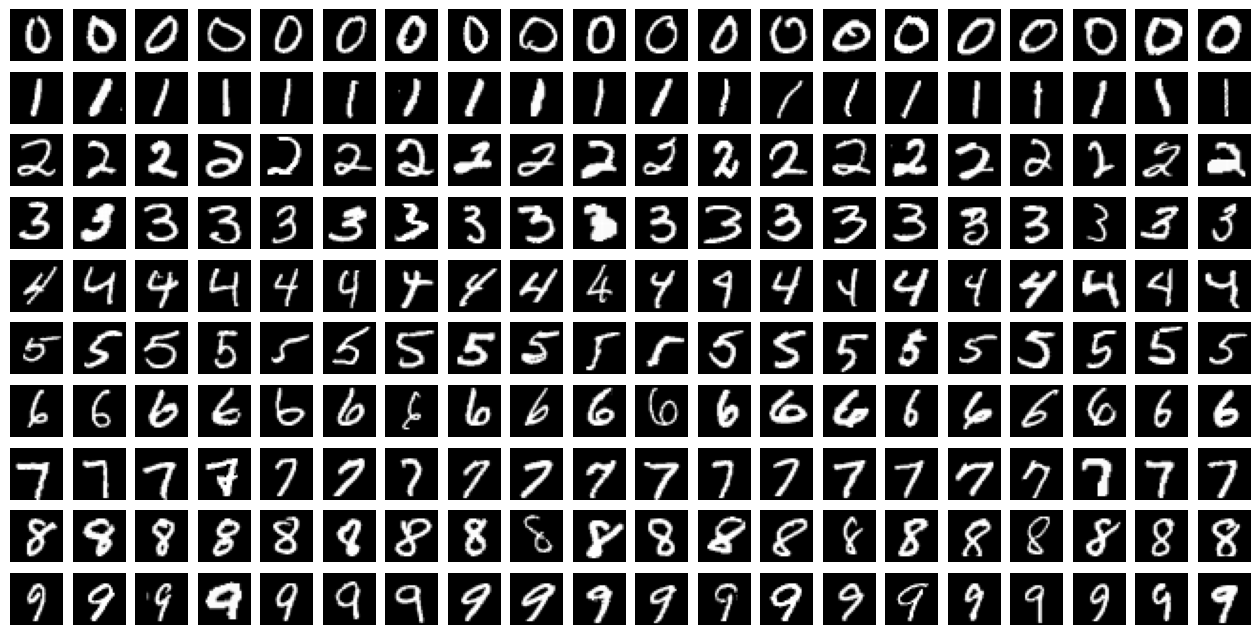

In [7]:
# Load and display images horizontally for each class
plt.figure(figsize=(16, 8))  # Adjust the figure size as needed
for class_label in range(10):
    class_folder = os.path.join(save_dir, str(class_label))
    images = load_images_from_folder(class_folder)
    for i, img in enumerate(images):
        plt.subplot(10, 20, class_label * 20 + i + 1)
        img = img.resize((28, 28))
        plt.imshow(img, cmap='gray')
        plt.axis('off')  # Hide axes

plt.show()

## Specific Digit

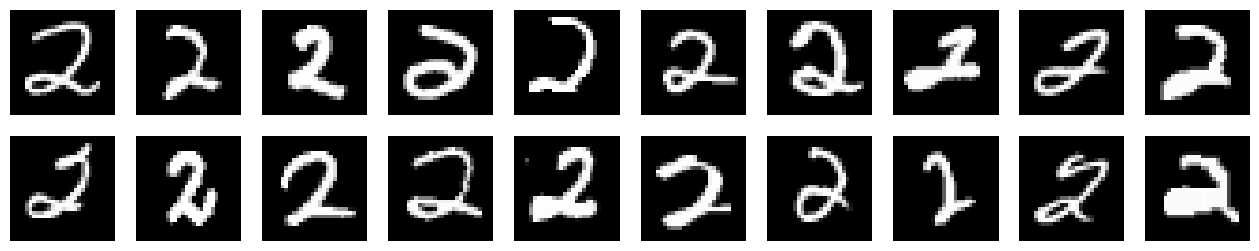

In [8]:
X = []
train_size = 20
class_label = 2  # 0-9
class_folder = os.path.join(save_dir, str(class_label))
images = load_images_from_folder(class_folder, max_images=train_size)

for k in range(1, len(images) + 1):
    img = images[k - 1]
    img = img.resize((28, 28))
    array_obj = np.asarray(img)
    X.append(array_obj)

X = np.array(X)

plt.figure(figsize=(16, 3))
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(X[i], cmap='gray', vmin=0, vmax=255) # [0, 255]
    plt.axis('off')  # Hide axes

plt.show()

### Regression on the Original Manifold

In [9]:
import cupy as cp

eta_hat_list = []

for i in range(X.shape[0]):
    D = len(X[i].shape)
    eps = np.asarray(1.0e-5)
    xp = cp.get_array_module(X[i])
    scaleX = xp.sum(X[i] + eps)
    P = (X[i] + eps) / scaleX
    eta_hat = get_eta(P, D, xp)
    eta_hat_list.append(eta_hat)

eta_hat_list_cp = cp.asarray(eta_hat_list)

In [10]:
# Do a linear approximate of the m-flat submanifold: compute the average eta_hat
average_eta_hat = cp.mean(eta_hat_list_cp, axis=0)
avg_eta_hat = cp.asnumpy(average_eta_hat)
print("Average eta_hat shape:", avg_eta_hat.shape)

# Compute RMSE (Relative Mean Squared Error)
rmse = cp.sqrt(cp.mean((eta_hat_list_cp - average_eta_hat) ** 2)) / cp.sqrt(cp.mean(eta_hat_list_cp ** 2))
# Compute RAE (Relative Absolute Error)
rae = cp.sum(cp.abs(eta_hat_list_cp - average_eta_hat)) / cp.sum(cp.abs(eta_hat_list_cp))

rmse_np = cp.asnumpy(rmse)
rae_np = cp.asnumpy(rae)

print("Relative Mean Squared Error (RMSE):", rmse_np)
print("Relative Absolute Error (RAE):", rae_np)

Average eta_hat shape: (28, 28)
Relative Mean Squared Error (RMSE): 0.0962138106287829
Relative Absolute Error (RAE): 0.09377812309567636


### Individual

In [11]:
# Initialize lists to store the results
scaleX_list = []
Q_list = []
theta_list = []

# Initialize a list to store reconstructed images
X_recons_list = []

for i in range(train_size):
    _, scaleX, Q, theta = LD(X[i], order=1, verbose=False, n_iter=100, lr=1e-4, exit_abs=True)
    scaleX_list.append(scaleX)
    Q_list.append(Q)
    theta_list.append(theta)
    X_recons = (Q * scaleX).astype(np.int32)
    X_recons_list.append(X_recons)

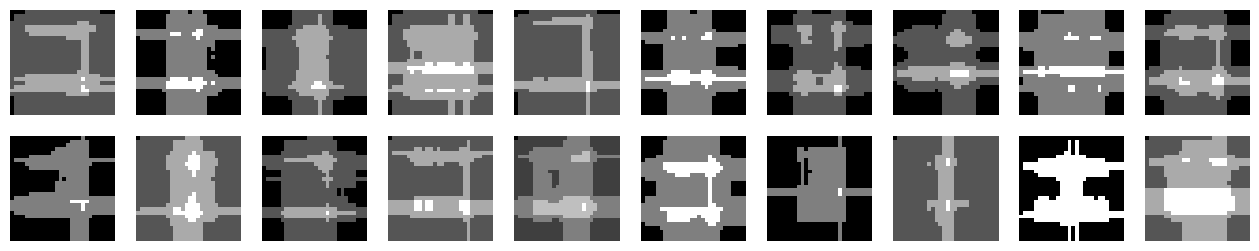

In [12]:
plt.figure(figsize=(16, 3))
for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(renormalize_image(X_recons_list[i]), cmap='gray', vmin=0, vmax=255) # [0, 255]
    plt.axis('off')

plt.show()

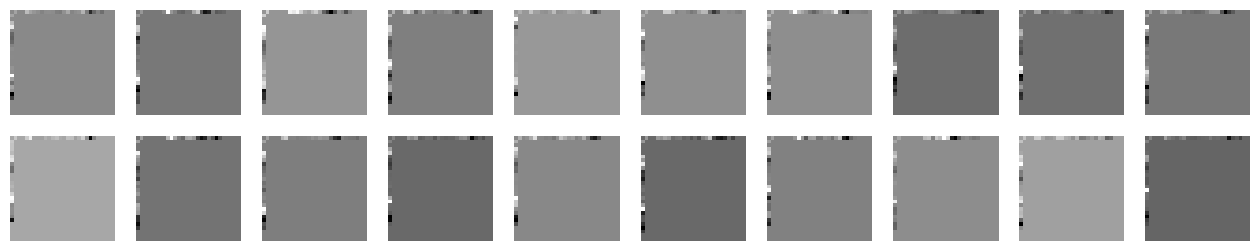

In [13]:
plt.figure(figsize=(16, 3))
for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(theta_list[i], cmap='gray')
    plt.axis('off')

plt.show()

#### Backward Projection

In [14]:
from ld import BP
# Compute the avg_scaleX
avg_scaleX = np.mean(scaleX_list)
B = block_B(10, 12)

P_list_BP = []
theta_list_BP = []

X_recons_list = []

for i in range(X.shape[0]):
    # noisy_eta_hat = avg_eta_hat + np.random.normal(0, 1e-8, avg_eta_hat.shape)
    _, P, theta = BP(Q_list[i], theta_list[i], avg_eta_hat, avg_scaleX, B=B, verbose=False, n_iter=100, lr=1e-4, exit_abs=True)
    P_list_BP.append(P)
    theta_list_BP.append(theta)

    X_recons = (P).astype(np.int32)
    X_recons_list.append(X_recons)

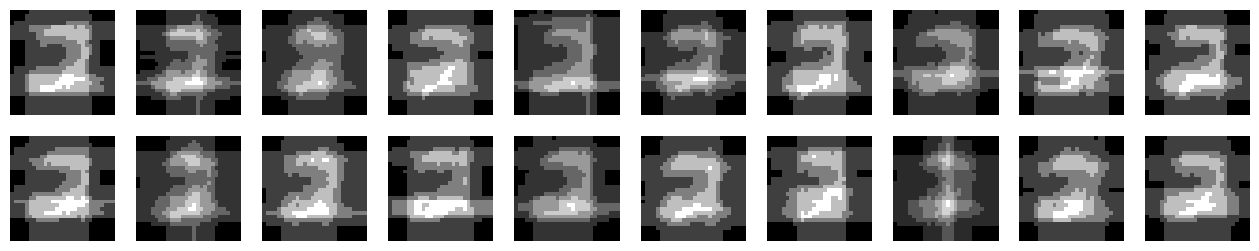

In [15]:
plt.figure(figsize=(16, 3))
for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(renormalize_image(X_recons_list[i]), cmap='gray', vmin=0, vmax=255) # [0, 255]
    plt.axis('off')
plt.show()

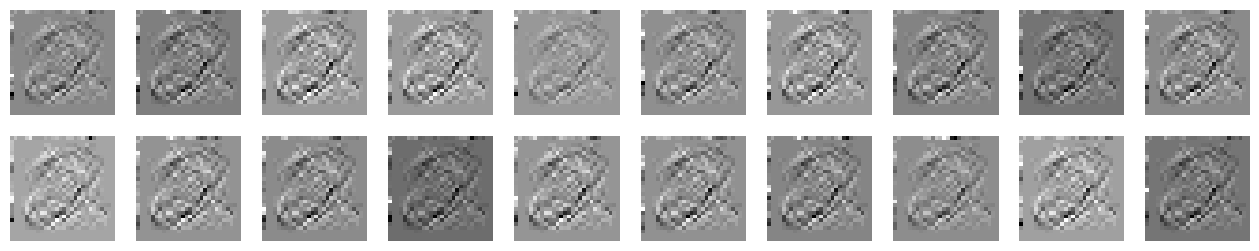

In [16]:
plt.figure(figsize=(16, 3))
for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(theta_list_BP[i], cmap='gray')
    plt.axis('off')
plt.show()

## Linear Interpolation

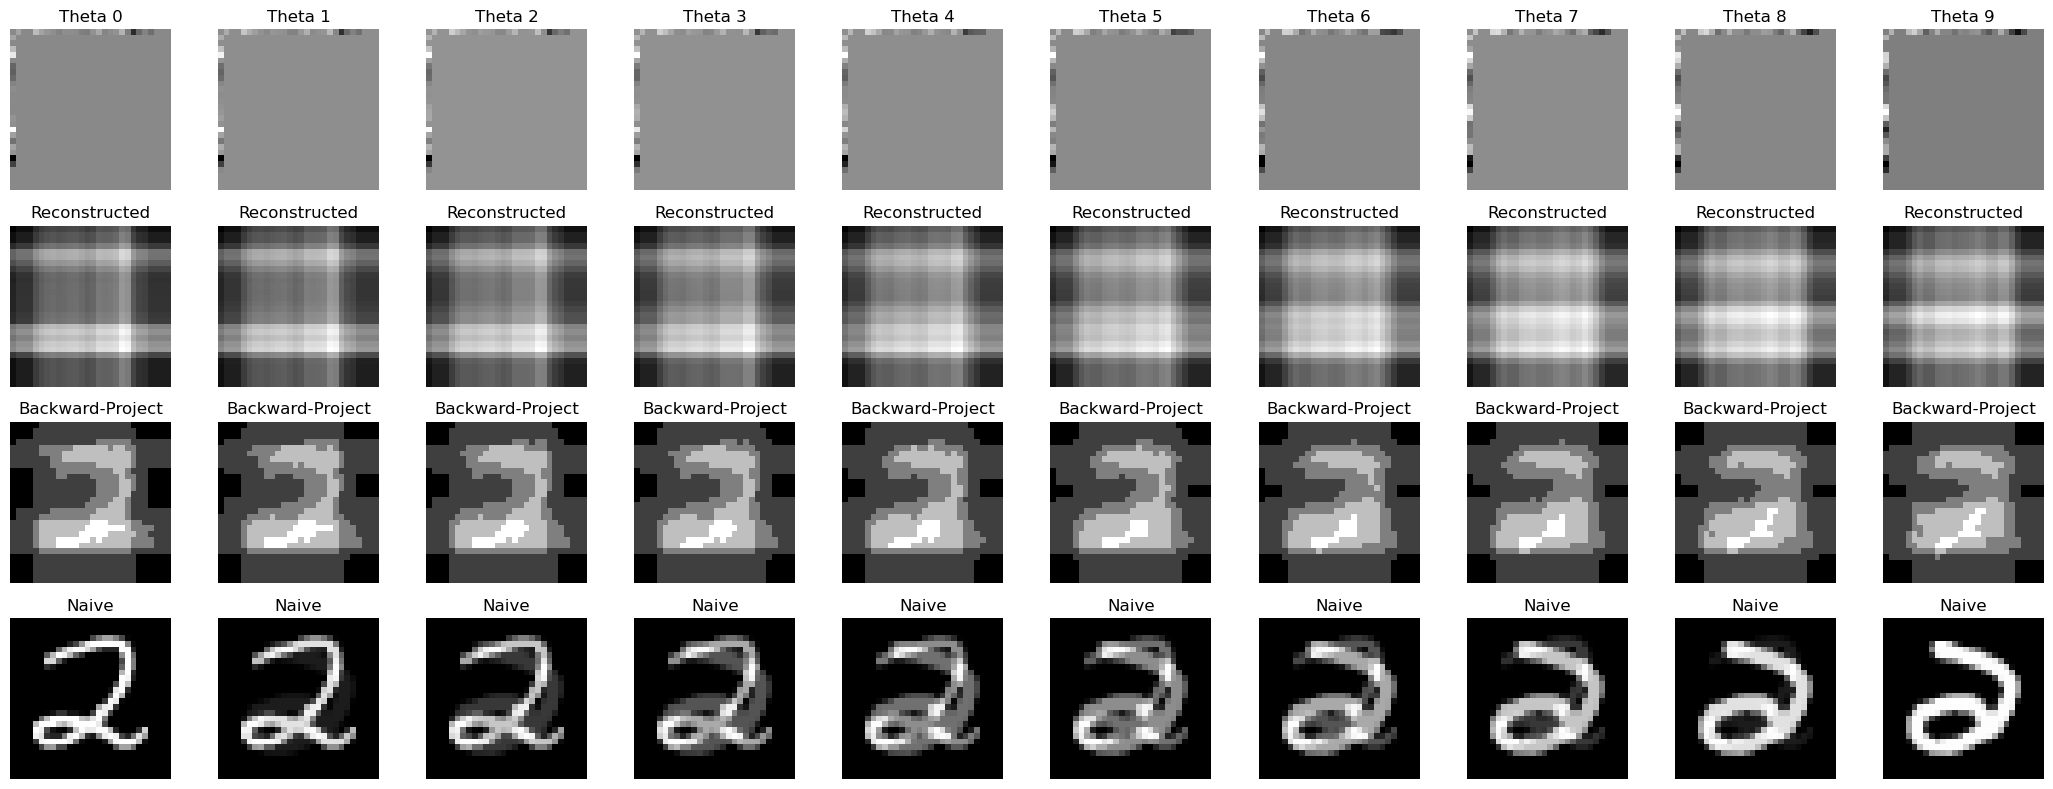

In [17]:
# Pick two random images's theta, and then linear interpolate and plot their images
theta_start, theta_end = theta_list[0], theta_list[3]
X_start, X_end = X[0].astype(np.int32), X[3].astype(np.int32)

delta_theta = theta_end - theta_start
delta_X = X_end - X_start

Q = compute_Q(theta_start)

# Backward-projection
fig, axes = plt.subplots(4, 10, figsize=(21, 8))

for i in range(10):
    theta = theta_start + delta_theta * i / 9
    X_ = X_start + delta_X * i / 9
    Q = compute_Q(theta)
    axes[0, i].imshow(theta.reshape(28, 28), cmap='gray')
    axes[0, i].set_title(f'Theta {i}')
    axes[0, i].axis('off')

    axes[1, i].imshow(renormalize_image(Q), cmap='gray', vmin=0, vmax=255) # [0, 255]
    axes[1, i].set_title('Reconstructed')
    axes[1, i].axis('off')

    all_history_kl, P, theta = BP(Q, theta, avg_eta_hat, avg_scaleX, order=1, verbose=False, n_iter=100, lr=1e-4, exit_abs=True)

    axes[2, i].imshow(renormalize_image((P).astype(np.int32)), cmap='gray', vmin=0, vmax=255) # [0, 255]
    axes[2, i].set_title('Backward-Project')
    axes[2, i].axis('off')

    axes[3, i].imshow(X_, cmap='gray', vmin=0, vmax=255) # [0, 255]
    axes[3, i].set_title('Naive')
    axes[3, i].axis('off')


plt.tight_layout()
plt.show()

## Fitting and Sampling

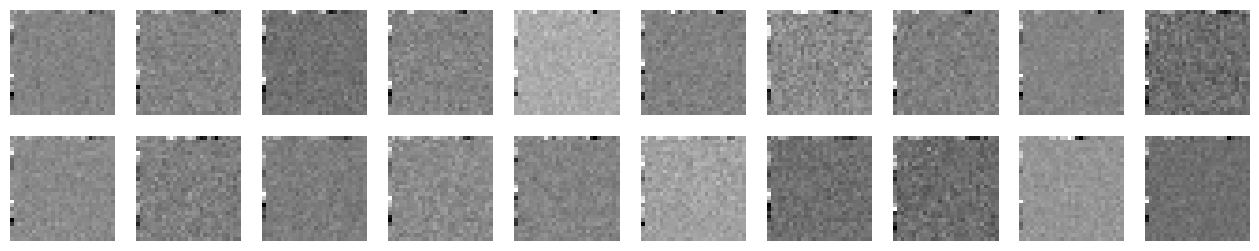

In [18]:
from sklearn.neighbors import KernelDensity
# Fit a KDE to the theta values
kde = KernelDensity(kernel='gaussian', bandwidth=0.001).fit(np.array(theta_list).reshape(train_size, -1))
# Sample new data from the KDE
num_new_samples = 20
sampled_theta = (kde.sample(n_samples=num_new_samples)).reshape(num_new_samples, 28, 28)

plt.figure(figsize=(16, 3))
for i in range(sampled_theta.shape[0]):
    plt.subplot(2, 10, i + 1)
    plt.imshow(sampled_theta[i], cmap='gray')
    plt.axis('off')
plt.show()

sampled_Q = []

for i in range(sampled_theta.shape[0]):
    sampled_Q.append(compute_Q(sampled_theta[i]))


In [19]:
# Compute the avg_scaleX
# B = block_B(10, 12)

sampled_P_list_BP = []
sampled_theta_list_BP = []
X_recons_list = []

for i in range(sampled_theta.shape[0]):
    # add noise to eta_hat
    _, P, theta = BP(sampled_Q[i], sampled_theta[i], avg_eta_hat, avg_scaleX, order=2, verbose=False, n_iter=100, lr=1e-4, exit_abs=True)
    sampled_P_list_BP.append(P)
    sampled_theta_list_BP.append(theta)

    X_recons = (P).astype(np.int32)
    X_recons_list.append(X_recons)

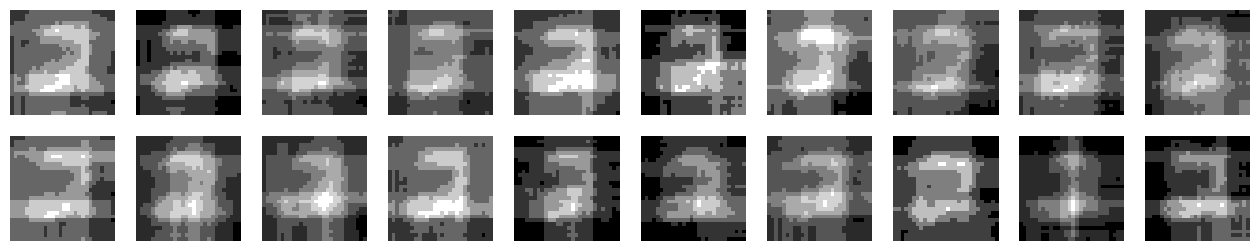

In [20]:
plt.figure(figsize=(16, 3))
for i in range(sampled_theta.shape[0]):
    plt.subplot(2, 10, i + 1)
    plt.imshow(renormalize_image(X_recons_list[i]), cmap='gray', vmin=0, vmax=255) # [0, 255]
    plt.axis('off')
plt.show()

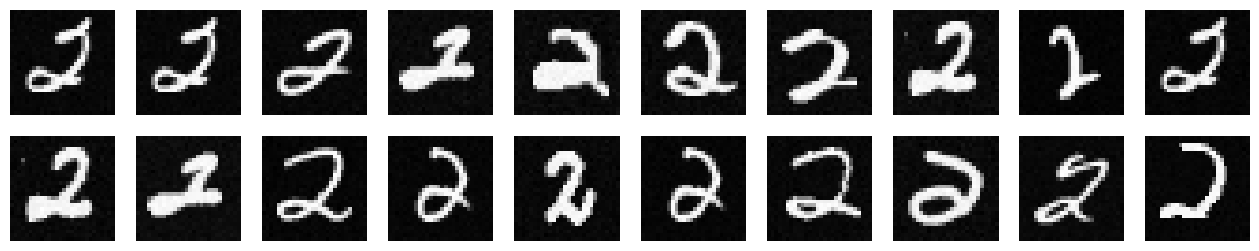

In [21]:
X_ = []
for i in range(X.shape[0]):
    # normalized X to be a probability distribution over the index set
    X_.append(X[i] / np.sum(X[i]))

# Fit a KDE to the theta values
kde = KernelDensity(kernel='gaussian', bandwidth=0.0001).fit(np.array(X_).reshape(train_size, -1))
# Sample new data from the KDE
num_new_samples = 20
sampled_X = (kde.sample(n_samples=num_new_samples)).reshape(num_new_samples, 28, 28)

plt.figure(figsize=(16, 3))
for i in range(sampled_theta.shape[0]):
    plt.subplot(2, 10, i + 1)
    plt.imshow(renormalize_image(sampled_X[i]), cmap='gray', vmin=0, vmax=255) # [0, 255]
    plt.axis('off')
plt.show()